# 10 Step Phase Shifting Technique

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from functions import load_raw_img, rad_to_deg, mask_to_dummy
from unwrapping_isoclinic import phase_unwrap_isoclinic
from unwrapping_algorithm import phase_unwrap

### Load the 10 images

In [5]:
base_path = "img/disc/phase-shifting/"
file_type = ".CR2"

file_names = os.listdir(base_path)

imgs = []

for file_name in file_names:
    imgs.append(load_raw_img(base_path + file_name)[:,:,1] / 10)

In [6]:
alphas = rad_to_deg(np.array([
    np.pi / 2, 
    5*np.pi/8, 
    3*np.pi/4, 
    7*np.pi/8, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2
]))

betas = rad_to_deg(np.array([
    0,
    np.pi/8,
    np.pi/4,
    3*np.pi/8,
    np.pi/2,
    0,
    0,
    np.pi/4,
    0,
    np.pi/2
]))

for i in range(len(alphas)):
    print(f'Alpha: {alphas[i]}, Beta: {betas[i]}')

Alpha: 90.0, Beta: 0.0
Alpha: 112.5, Beta: 22.5
Alpha: 135.0, Beta: 45.0
Alpha: 157.5, Beta: 67.5
Alpha: 90.0, Beta: 90.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 45.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 90.0


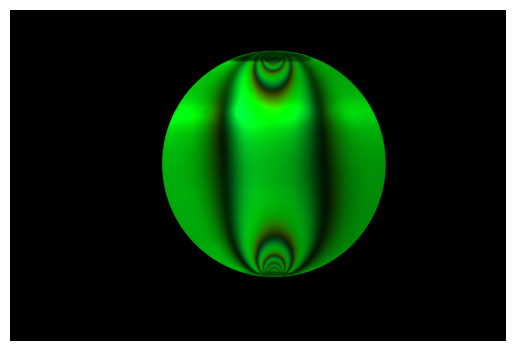

In [7]:
mask = cv.imread('img/disc/mask/disc_mask_phase_shifting_2.jpg', cv.IMREAD_GRAYSCALE)
c_mask = np.zeros((4022,6024,3))
for i in range(3):
    c_mask[:,:,i] = mask
example = cv.multiply(load_raw_img('img/disc/phase-shifting/IMG_3955.CR2').astype(float), c_mask / 255) / 255
plt.axis('off')
plt.imshow(example)
plt.imsave('img/disc/results/disc_image_masked.jpg', example)

### Calculate the isoclinic parameter
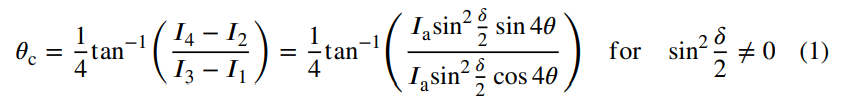

In [8]:
def generate_isoclinic_param(
        img_1: np.ndarray, 
        img_2: np.ndarray, 
        img_3: np.ndarray, 
        img_4: np.ndarray
) -> np.ndarray:
    """
    Images should be in order defined by Ramesh et al. 
    Returns the isoclinic parameter
    """
    return 1/4 * np.arctan2((img_4 - img_2),(img_3 - img_1))

In [9]:
isoclinic_param = generate_isoclinic_param(imgs[0], imgs[1], imgs[2], imgs[3])

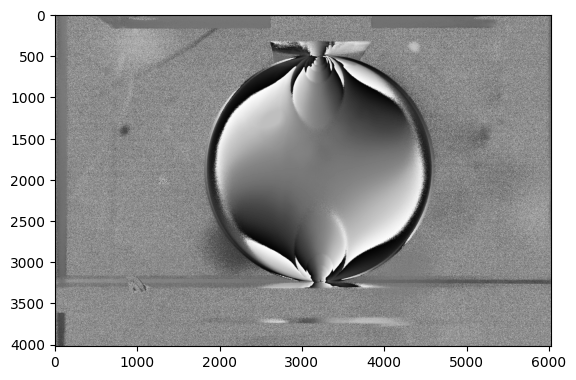

In [10]:
filename = 'img/disc/results/disc_isocl_wr.jpg'
plt.imshow(isoclinic_param, cmap='gray')
plt.imsave(filename, isoclinic_param, cmap='gray')

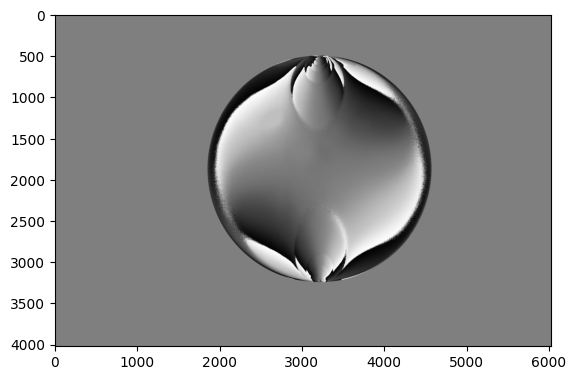

In [11]:
isoclinic_masked = cv.multiply(isoclinic_param, mask / 255)
plt.imshow(isoclinic_masked, cmap='gray')
plt.imsave('img/disc/results/disc_isocl_wr_masked.jpg',  isoclinic_masked, cmap='gray')

In [12]:
isoclinic_to_unwrap = cv.medianBlur(cv.imread(filename, cv.IMREAD_GRAYSCALE), 5) 

# Set stack as isotropic points
stack = [(2700, 3700), (2700, 2700), (900, 2700), (900, 3000), (900, 3300), (900, 3600)]
#create dummy array to be populated by unwrapped pixels
dummy = mask_to_dummy(mask)

isoclinic_unwrapped = phase_unwrap_isoclinic(isoclinic_to_unwrap, stack, dummy)

0 6
500000 4296
1000000 5483
1500000 6089
2000000 6002
2500000 5556
3000000 4964
3500000 4968
4000000 4943
4500000 4381
5000000 2727
5500000 1496


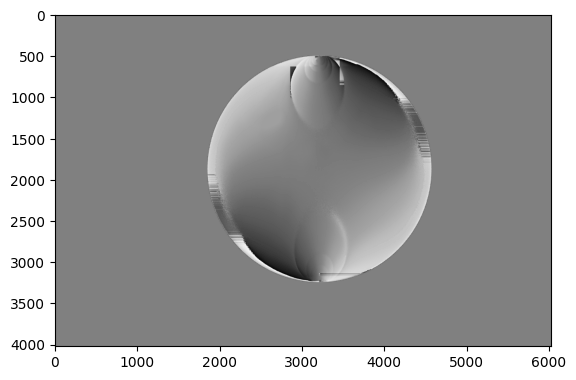

In [13]:
plt.imshow(isoclinic_unwrapped, cmap='gray')
plt.imsave('img/disc/results/disc_isocl_unwr.jpg', np.nan_to_num(isoclinic_unwrapped), cmap='gray')

### Generate isochromatic parameter
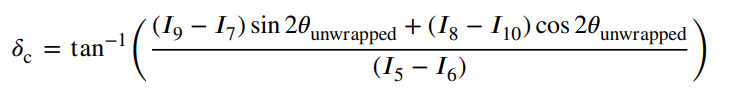


In [14]:
def generate_isochromatic_param(
    img_5: np.ndarray,
    img_6: np.ndarray,
    img_7: np.ndarray,
    img_8: np.ndarray,
    img_9: np.ndarray,
    img_10: np.ndarray,
    isoclinic_param: np.ndarray
) -> np.ndarray:
    return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) + 
                      (img_8 - img_10)*np.cos(2*isoclinic_param))/(img_5 - img_6))

In [15]:
isochromatic_param_rad = np.nan_to_num(generate_isochromatic_param(
    imgs[4],
    imgs[5],
    imgs[6],
    imgs[7],
    imgs[8],
    imgs[9],
    isoclinic_unwrapped
))

C:\Users\fredd\AppData\Local\Temp\ipykernel_3872\3016659149.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +
C:\Users\fredd\AppData\Local\Temp\ipykernel_3872\3016659149.py:10: RuntimeWarning: invalid value encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +


Translate `isochromatic_param` values from `(-pi/2, pi/2)` to `(0, 255)`

In [16]:
isochromatic_param = (isochromatic_param_rad + np.pi/2)*255/(np.pi)

## Isochromatic Image Processing

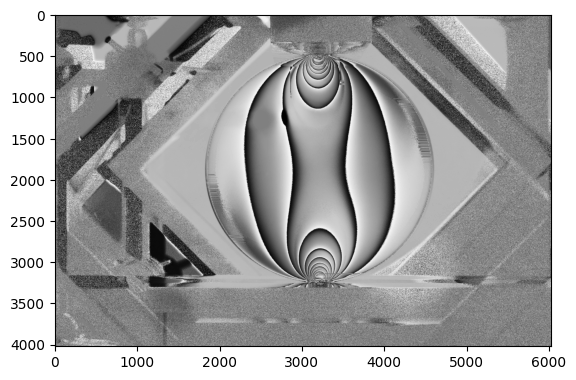

In [17]:
filename = 'img/disc/results/disc_isochr_wr_isocl_unwr.jpg'
plt.imshow(isochromatic_param, cmap='gray')
plt.imsave(filename, isochromatic_param, cmap='gray')

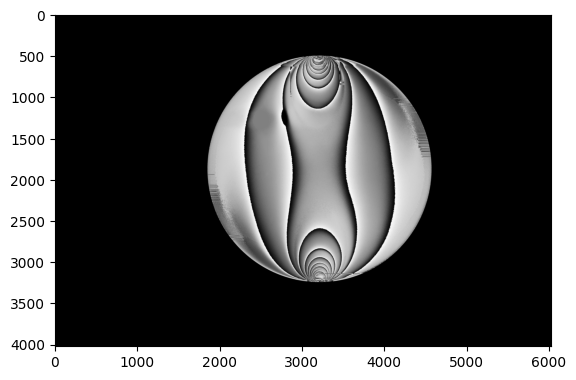

In [18]:
isochromatic_masked = cv.multiply(isochromatic_param, mask / 255)
isochromatic_masked = cv.medianBlur(isochromatic_masked.astype(np.uint8), 5)

plt.imshow(isochromatic_masked, cmap='gray')
plt.imsave('img/disc/results/disc_isochr_wr_isocl_unwr_masked.jpg',  isochromatic_masked, cmap='gray')

In [24]:
np.save('img/disc/results/disc_isochr_wr_isocl_unwr.npy', isochromatic_param / 255)

0 2
500000 2810
1000000 3394
1500000 3792
2000000 3897
2500000 4015
3000000 3904
3500000 3492
4000000 3161
4500000 2749
5000000 2224
5500000 1426


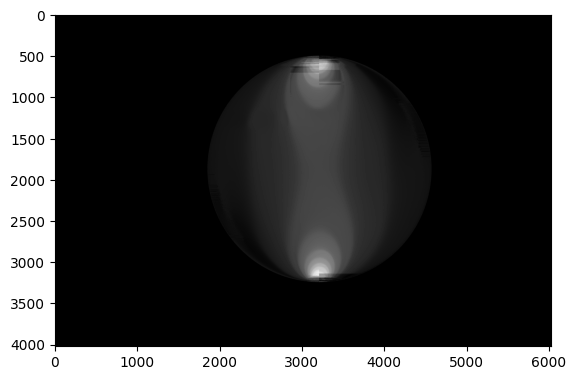

In [20]:
# Set stack as isotropic points
stack = [(2000, 2200), (2000, 4200)]
#create dummy array to be populated by unwrapped pixels
dummy = mask_to_dummy(mask)

isochromatic_unwrapped = phase_unwrap(isochromatic_masked, stack, dummy)

plt.imshow(isochromatic_unwrapped, cmap='gray')

In [21]:
filename = 'img/disc/results/disc_isochr_unwr_isocl_unwr.jpg'
plt.imsave(filename, isochromatic_unwrapped, cmap='gray')
np.save('img/disc/results/disc_isochr_unwr_isocl_unwr.npy', isochromatic_unwrapped)


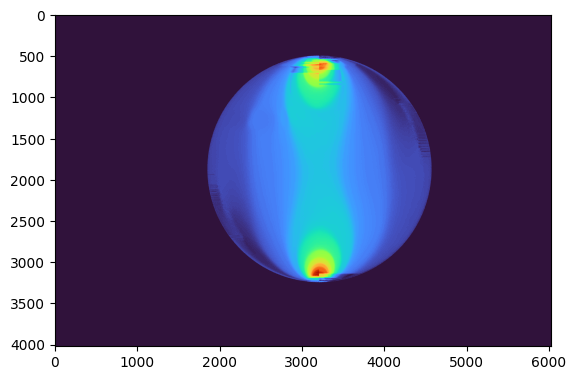

In [22]:
img = cv.medianBlur(cv.imread(filename, cv.IMREAD_GRAYSCALE), 5) 
plt.imshow(img, cmap='turbo')
plt.imsave('img/disc/results/disc_isochr_unwr_isocl_unwr_colour.jpg', isochromatic_unwrapped, cmap='turbo')